Runs the analyses presented in the section *Validating $logodds_R$ as a measure of politically conditioned variation*.

In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pickle
from scipy import stats
from statsmodels.stats import proportion
from pyspan.config import *

/Users/sabinasloman/Box/LoP/pyspan/pyspan/config.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sabinasloman/.pyenv/versions/2.7.17/envs/lop_env/lib/python2.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  

In [3]:
# Load data
df_crec = pickle.load(open("{}signals-unigrams".format(crec_paths["metrics_dir"]), 
                           "rb"))
df_debates = pickle.load(open("{}signals-unigrams".format(debate_paths["metrics_dir"]), 
                              "rb"))

In [4]:
# Create a new df containing only the words from the CRec data that
# also show up in the debate data
df = df_crec.join(df_debates, how = "inner", lsuffix = "_c", 
                  rsuffix = "_d")

Calculates the correlation between the $logodds_R$ values calculated using the Congressional Record and the Presidential debates.

In [5]:
cvec = df.rmetric_c.values
dvec = df.rmetric_d.values

In [6]:
%%R -i cvec,dvec
cor.test(cvec, dvec, alternative="greater")


	Pearson's product-moment correlation

data:  cvec and dvec
t = 17.412, df = 2406, p-value < 2.2e-16
alternative hypothesis: true correlation is greater than 0
95 percent confidence interval:
 0.3044104 1.0000000
sample estimates:
      cor 
0.3345241 



In [7]:
nobs = len(df)

Creates S1 Fig.

In [8]:
df.sort_values(["rmetric_c"], inplace=True)

Text(0,0.5,"Pearson's $R$")

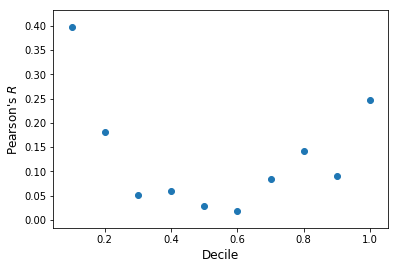

In [9]:
ii = np.linspace(0, nobs, 11)
cors = []
for i in range(10):
    sm_df = df[int(round(ii[i])):int(round(ii[i+1]))]
    cors += [stats.pearsonr(sm_df.rmetric_c, sm_df.rmetric_d)[0]]
plt.scatter(x=np.linspace(.1, 1, 10), y=cors)
plt.xlabel("Decile", fontsize=12)
plt.ylabel(r"Pearson's $R$", fontsize=12)

Binomial test.

In [10]:
# Create a new df containing only the words from the CRec data that
# "cross-validate" to the debate data
cv = np.apply_along_axis(lambda i: df.loc[i]["dmetric_c"] * df.loc[i]["dmetric_d"] <= 0,
                         0, df.index)
ma = np.ma.masked_array(df.index, mask = cv)
df = df.loc[ma.compressed()]
df.sort_values(["dmetric_c"], inplace = True)

In [11]:
# Number of words that "cross-validate"
print len(df)
# Proportion of words that "cross-validate"
p_ = len(df) / nobs
print p_
# SE of this proportion
print np.sqrt((p_ * (1-p_)) / (nobs-1))

1421
0.59011627907
0.01002446231587102


In [12]:
proportion.binom_test(len(df), nobs, alternative="larger")

4.469887372441423e-19